In [1]:
import os
import torch
import numpy as np

# CODE FILES HERE
from models.tdcvae.tdcvae import Encoder, Decoder, TD_Cvae, MODEL_NAME
from solver import Solver
from dataloader import DataLoader
from directories import Directories
from plots import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space,\
plot_latent_manifold, plot_prepro_params_distribution, plot_prepro_params_distribution_categories,\
plot_prepro_alpha_params_distribution, plot_prepro_radius_params_distribution, plot_faces_grid, plot_faces_samples_grid

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')
# VARIABLES HERE
load_model = False

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

optimizer = torch.optim.Adam
num_generations = 6

if dataset == "MNIST":
    batch_size = 128
    epochs = 5
    hidden_dim = 500
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 50,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [-180, 180],
        "theta_2": [-30, 30]
    }
    scales = {
        "scale_1": [0.5, 0.9],
        "scale_2": [0.2, 0.4]
    }
if dataset == "LungScans":
    batch_size = 4
    epochs = 1
    hidden_dim = 1000
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    resize = (80, 80)
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [-45, 45],
        "theta_2": [-10, 10]
    }
    scales = {
        "scale_1": [0.5, 0.9],
        "scale_2": [0.2, 0.4]
    }

In [4]:
directories = Directories(MODEL_NAME, dataset, z_dim, False)
data_loader = DataLoader(directories, batch_size, dataset, num_generations=num_generations, thetas=thetas)
model = TD_Cvae(data_loader.input_dim, hidden_dim, data_loader.input_dim, z_dim)
solver = Solver(model, data_loader, optimizer, z_dim, epochs, beta, optim_config, step_config=step_config, lr_scheduler=lr_scheduler, tdcvae_mode=True)
solver.main()

+++++ START RUN +++++ | no save mode
new theta1 and theta2! 0
new theta1 and theta2! 128
new theta1 and theta2! 256
new theta1 and theta2! 384
new theta1 and theta2! 512
new theta1 and theta2! 640
new theta1 and theta2! 768
new theta1 and theta2! 896
new theta1 and theta2! 1024
new theta1 and theta2! 1152
new theta1 and theta2! 1280
new theta1 and theta2! 1408
new theta1 and theta2! 1536
new theta1 and theta2! 1664
new theta1 and theta2! 1792
new theta1 and theta2! 1920
new theta1 and theta2! 2048
new theta1 and theta2! 2176
new theta1 and theta2! 2304
new theta1 and theta2! 2432
new theta1 and theta2! 2560
new theta1 and theta2! 2688
new theta1 and theta2! 2816
new theta1 and theta2! 2944
new theta1 and theta2! 3072
new theta1 and theta2! 3200
new theta1 and theta2! 3328
new theta1 and theta2! 3456
new theta1 and theta2! 3584
new theta1 and theta2! 3712
new theta1 and theta2! 3840
new theta1 and theta2! 3968
new theta1 and theta2! 4096
new theta1 and theta2! 4224
new theta1 and theta2

new theta1 and theta2! 36480
new theta1 and theta2! 36608
new theta1 and theta2! 36736
new theta1 and theta2! 36864
new theta1 and theta2! 36992
new theta1 and theta2! 37120
new theta1 and theta2! 37248
new theta1 and theta2! 37376
new theta1 and theta2! 37504
new theta1 and theta2! 37632
new theta1 and theta2! 37760
new theta1 and theta2! 37888
new theta1 and theta2! 38016
new theta1 and theta2! 38144
new theta1 and theta2! 38272
new theta1 and theta2! 38400
new theta1 and theta2! 38528
new theta1 and theta2! 38656
new theta1 and theta2! 38784
new theta1 and theta2! 38912
new theta1 and theta2! 39040
new theta1 and theta2! 39168
new theta1 and theta2! 39296
new theta1 and theta2! 39424
new theta1 and theta2! 39552
new theta1 and theta2! 39680
new theta1 and theta2! 39808
new theta1 and theta2! 39936
new theta1 and theta2! 40064
new theta1 and theta2! 40192
new theta1 and theta2! 40320
new theta1 and theta2! 40448
new theta1 and theta2! 40576
new theta1 and theta2! 40704
new theta1 and

new theta1 and theta2! 62592
new theta1 and theta2! 62720
new theta1 and theta2! 62848
new theta1 and theta2! 62976
new theta1 and theta2! 63104
new theta1 and theta2! 63232
new theta1 and theta2! 63360
new theta1 and theta2! 63488
new theta1 and theta2! 63616
new theta1 and theta2! 63744
new theta1 and theta2! 63872
new theta1 and theta2! 64000
new theta1 and theta2! 64128
new theta1 and theta2! 64256
new theta1 and theta2! 64384
new theta1 and theta2! 64512
new theta1 and theta2! 64640
new theta1 and theta2! 64768
new theta1 and theta2! 64896
new theta1 and theta2! 65024
new theta1 and theta2! 65152
new theta1 and theta2! 65280
new theta1 and theta2! 65408
new theta1 and theta2! 65536
new theta1 and theta2! 65664
new theta1 and theta2! 65792
new theta1 and theta2! 65920
new theta1 and theta2! 66048
new theta1 and theta2! 66176
new theta1 and theta2! 66304
new theta1 and theta2! 66432
new theta1 and theta2! 66560
new theta1 and theta2! 66688
new theta1 and theta2! 66816
new theta1 and

new theta1 and theta2! 98944
new theta1 and theta2! 99072
new theta1 and theta2! 99200
new theta1 and theta2! 99328
new theta1 and theta2! 99456
new theta1 and theta2! 99584
new theta1 and theta2! 99712
new theta1 and theta2! 99840
new theta1 and theta2! 99968
new theta1 and theta2! 100096
new theta1 and theta2! 100224
new theta1 and theta2! 100352
new theta1 and theta2! 100480
new theta1 and theta2! 100608
new theta1 and theta2! 100736
new theta1 and theta2! 100864
new theta1 and theta2! 100992
new theta1 and theta2! 101120
new theta1 and theta2! 101248
new theta1 and theta2! 101376
new theta1 and theta2! 101504
new theta1 and theta2! 101632
new theta1 and theta2! 101760
new theta1 and theta2! 101888
new theta1 and theta2! 102016
new theta1 and theta2! 102144
new theta1 and theta2! 102272
new theta1 and theta2! 102400
new theta1 and theta2! 102528
new theta1 and theta2! 102656
new theta1 and theta2! 102784
new theta1 and theta2! 102912
new theta1 and theta2! 103040
new theta1 and thet

new theta1 and theta2! 124032
new theta1 and theta2! 124160
new theta1 and theta2! 124288
new theta1 and theta2! 124416
new theta1 and theta2! 124544
new theta1 and theta2! 124672
new theta1 and theta2! 124800
new theta1 and theta2! 124928
new theta1 and theta2! 125056
new theta1 and theta2! 125184
new theta1 and theta2! 125312
new theta1 and theta2! 125440
new theta1 and theta2! 125568
new theta1 and theta2! 125696
new theta1 and theta2! 125824
new theta1 and theta2! 125952
new theta1 and theta2! 126080
new theta1 and theta2! 126208
new theta1 and theta2! 126336
new theta1 and theta2! 126464
new theta1 and theta2! 126592
new theta1 and theta2! 126720
new theta1 and theta2! 126848
new theta1 and theta2! 126976
new theta1 and theta2! 127104
new theta1 and theta2! 127232
new theta1 and theta2! 127360
new theta1 and theta2! 127488
new theta1 and theta2! 127616
new theta1 and theta2! 127744
new theta1 and theta2! 127872
new theta1 and theta2! 128000
new theta1 and theta2! 128128
new theta1

new theta1 and theta2! 159104
new theta1 and theta2! 159232
new theta1 and theta2! 159360
new theta1 and theta2! 159488
new theta1 and theta2! 159616
new theta1 and theta2! 159744
new theta1 and theta2! 159872
new theta1 and theta2! 160000
new theta1 and theta2! 160128
new theta1 and theta2! 160256
new theta1 and theta2! 160384
new theta1 and theta2! 160512
new theta1 and theta2! 160640
new theta1 and theta2! 160768
new theta1 and theta2! 160896
new theta1 and theta2! 161024
new theta1 and theta2! 161152
new theta1 and theta2! 161280
new theta1 and theta2! 161408
new theta1 and theta2! 161536
new theta1 and theta2! 161664
new theta1 and theta2! 161792
new theta1 and theta2! 161920
new theta1 and theta2! 162048
new theta1 and theta2! 162176
new theta1 and theta2! 162304
new theta1 and theta2! 162432
new theta1 and theta2! 162560
new theta1 and theta2! 162688
new theta1 and theta2! 162816
new theta1 and theta2! 162944
new theta1 and theta2! 163072
new theta1 and theta2! 163200
new theta1

new theta1 and theta2! 184064
new theta1 and theta2! 184192
new theta1 and theta2! 184320
new theta1 and theta2! 184448
new theta1 and theta2! 184576
new theta1 and theta2! 184704
new theta1 and theta2! 184832
new theta1 and theta2! 184960
new theta1 and theta2! 185088
new theta1 and theta2! 185216
new theta1 and theta2! 185344
new theta1 and theta2! 185472
new theta1 and theta2! 185600
new theta1 and theta2! 185728
new theta1 and theta2! 185856
new theta1 and theta2! 185984
new theta1 and theta2! 186112
new theta1 and theta2! 186240
new theta1 and theta2! 186368
new theta1 and theta2! 186496
new theta1 and theta2! 186624
new theta1 and theta2! 186752
new theta1 and theta2! 186880
new theta1 and theta2! 187008
new theta1 and theta2! 187136
new theta1 and theta2! 187264
new theta1 and theta2! 187392
new theta1 and theta2! 187520
new theta1 and theta2! 187648
new theta1 and theta2! 187776
new theta1 and theta2! 187904
new theta1 and theta2! 188032
new theta1 and theta2! 188160
new theta1

new theta1 and theta2! 219136
new theta1 and theta2! 219264
new theta1 and theta2! 219392
new theta1 and theta2! 219520
new theta1 and theta2! 219648
new theta1 and theta2! 219776
new theta1 and theta2! 219904
new theta1 and theta2! 220032
new theta1 and theta2! 220160
new theta1 and theta2! 220288
new theta1 and theta2! 220416
new theta1 and theta2! 220544
new theta1 and theta2! 220672
new theta1 and theta2! 220800
new theta1 and theta2! 220928
new theta1 and theta2! 221056
new theta1 and theta2! 221184
new theta1 and theta2! 221312
new theta1 and theta2! 221440
new theta1 and theta2! 221568
new theta1 and theta2! 221696
new theta1 and theta2! 221824
new theta1 and theta2! 221952
new theta1 and theta2! 222080
new theta1 and theta2! 222208
new theta1 and theta2! 222336
new theta1 and theta2! 222464
new theta1 and theta2! 222592
new theta1 and theta2! 222720
new theta1 and theta2! 222848
new theta1 and theta2! 222976
new theta1 and theta2! 223104
new theta1 and theta2! 223232
new theta1

new theta1 and theta2! 244864
42
new theta1 and theta2! 245120
new theta1 and theta2! 245248
new theta1 and theta2! 245376
new theta1 and theta2! 245504
new theta1 and theta2! 245632
48
new theta1 and theta2! 245888
new theta1 and theta2! 246016
new theta1 and theta2! 246144
new theta1 and theta2! 246272
new theta1 and theta2! 246400
54
new theta1 and theta2! 246656
new theta1 and theta2! 246784
new theta1 and theta2! 246912
new theta1 and theta2! 247040
new theta1 and theta2! 247168
60
new theta1 and theta2! 247424
new theta1 and theta2! 247552
new theta1 and theta2! 247680
new theta1 and theta2! 247808
new theta1 and theta2! 247936
66
new theta1 and theta2! 248192
new theta1 and theta2! 248320
new theta1 and theta2! 248448
new theta1 and theta2! 248576
new theta1 and theta2! 248704
72
new theta1 and theta2! 248960
new theta1 and theta2! 249088
new theta1 and theta2! 249216
new theta1 and theta2! 249344
new theta1 and theta2! 249472
78
new theta1 and theta2! 249728
new theta1 and thet

new theta1 and theta2! 285952
new theta1 and theta2! 286080
new theta1 and theta2! 286208
new theta1 and theta2! 286336
366
new theta1 and theta2! 286592
new theta1 and theta2! 286720
new theta1 and theta2! 286848
new theta1 and theta2! 286976
new theta1 and theta2! 287104
372
new theta1 and theta2! 287360
new theta1 and theta2! 287488
new theta1 and theta2! 287616
new theta1 and theta2! 287744
new theta1 and theta2! 287872
378
new theta1 and theta2! 288128
new theta1 and theta2! 288256
new theta1 and theta2! 288384
new theta1 and theta2! 288512
new theta1 and theta2! 288640
384
new theta1 and theta2! 288896
new theta1 and theta2! 289024
new theta1 and theta2! 289152
new theta1 and theta2! 289280
new theta1 and theta2! 289408
390
new theta1 and theta2! 289664
new theta1 and theta2! 289792
new theta1 and theta2! 289920
new theta1 and theta2! 290048
new theta1 and theta2! 290176
396
new theta1 and theta2! 290432
new theta1 and theta2! 290560
new theta1 and theta2! 290688
new theta1 and t

new theta1 and theta2! 326912
new theta1 and theta2! 327040
684
new theta1 and theta2! 327296
new theta1 and theta2! 327424
new theta1 and theta2! 327552
new theta1 and theta2! 327680
new theta1 and theta2! 327808
690
new theta1 and theta2! 328064
new theta1 and theta2! 328192
new theta1 and theta2! 328320
new theta1 and theta2! 328448
new theta1 and theta2! 328576
696
new theta1 and theta2! 328832
new theta1 and theta2! 328960
new theta1 and theta2! 329088
new theta1 and theta2! 329216
new theta1 and theta2! 329344
702
new theta1 and theta2! 329600
new theta1 and theta2! 329728
new theta1 and theta2! 329856
new theta1 and theta2! 329984
new theta1 and theta2! 330112
708
new theta1 and theta2! 330368
new theta1 and theta2! 330496
new theta1 and theta2! 330624
new theta1 and theta2! 330752
new theta1 and theta2! 330880
714
new theta1 and theta2! 331136
new theta1 and theta2! 331264
new theta1 and theta2! 331392
new theta1 and theta2! 331520
new theta1 and theta2! 331648
720
new theta1 a

1002
new theta1 and theta2! 368000
new theta1 and theta2! 368128
new theta1 and theta2! 368256
new theta1 and theta2! 368384
new theta1 and theta2! 368512
1008
new theta1 and theta2! 368768
new theta1 and theta2! 368896
new theta1 and theta2! 369024
new theta1 and theta2! 369152
new theta1 and theta2! 369280
1014
new theta1 and theta2! 369536
new theta1 and theta2! 369664
new theta1 and theta2! 369792
new theta1 and theta2! 369920
new theta1 and theta2! 370048
1020
new theta1 and theta2! 370304
new theta1 and theta2! 370432
new theta1 and theta2! 370560
new theta1 and theta2! 370688
new theta1 and theta2! 370816
1026
new theta1 and theta2! 371072
new theta1 and theta2! 371200
new theta1 and theta2! 371328
new theta1 and theta2! 371456
new theta1 and theta2! 371584
1032
new theta1 and theta2! 371840
new theta1 and theta2! 371968
new theta1 and theta2! 372096
new theta1 and theta2! 372224
new theta1 and theta2! 372352
1038
new theta1 and theta2! 372608
new theta1 and theta2! 372736
new t

1320
new theta1 and theta2! 408704
new theta1 and theta2! 408832
new theta1 and theta2! 408960
new theta1 and theta2! 409088
new theta1 and theta2! 409216
1326
new theta1 and theta2! 409472
new theta1 and theta2! 409600
new theta1 and theta2! 409728
new theta1 and theta2! 409856
new theta1 and theta2! 409984
1332
new theta1 and theta2! 410240
new theta1 and theta2! 410368
new theta1 and theta2! 410496
new theta1 and theta2! 410624
new theta1 and theta2! 410752
1338
new theta1 and theta2! 411008
new theta1 and theta2! 411136
new theta1 and theta2! 411264
new theta1 and theta2! 411392
new theta1 and theta2! 411520
1344
new theta1 and theta2! 411776
new theta1 and theta2! 411904
new theta1 and theta2! 412032
new theta1 and theta2! 412160
new theta1 and theta2! 412288
1350
new theta1 and theta2! 412544
new theta1 and theta2! 412672
new theta1 and theta2! 412800
new theta1 and theta2! 412928
new theta1 and theta2! 413056
1356
new theta1 and theta2! 413312
new theta1 and theta2! 413440
new t

1638
new theta1 and theta2! 449408
new theta1 and theta2! 449536
new theta1 and theta2! 449664
new theta1 and theta2! 449792
new theta1 and theta2! 449920
1644
new theta1 and theta2! 450176
new theta1 and theta2! 450304
new theta1 and theta2! 450432
new theta1 and theta2! 450560
new theta1 and theta2! 450688
1650
new theta1 and theta2! 450944
new theta1 and theta2! 451072
new theta1 and theta2! 451200
new theta1 and theta2! 451328
new theta1 and theta2! 451456
1656
new theta1 and theta2! 451712
new theta1 and theta2! 451840
new theta1 and theta2! 451968
new theta1 and theta2! 452096
new theta1 and theta2! 452224
1662
new theta1 and theta2! 452480
new theta1 and theta2! 452608
new theta1 and theta2! 452736
new theta1 and theta2! 452864
new theta1 and theta2! 452992
1668
new theta1 and theta2! 453248
new theta1 and theta2! 453376
new theta1 and theta2! 453504
new theta1 and theta2! 453632
new theta1 and theta2! 453760
1674
new theta1 and theta2! 454016
new theta1 and theta2! 454144
new t

1956
new theta1 and theta2! 490112
new theta1 and theta2! 490240
new theta1 and theta2! 490368
new theta1 and theta2! 490496
new theta1 and theta2! 490624
1962
new theta1 and theta2! 490880
new theta1 and theta2! 491008
new theta1 and theta2! 491136
new theta1 and theta2! 491264
new theta1 and theta2! 491392
1968
new theta1 and theta2! 491648
new theta1 and theta2! 491776
new theta1 and theta2! 491904
new theta1 and theta2! 492032
new theta1 and theta2! 492160
1974
new theta1 and theta2! 492416
new theta1 and theta2! 492544
new theta1 and theta2! 492672
new theta1 and theta2! 492800
new theta1 and theta2! 492928
1980
new theta1 and theta2! 493184
new theta1 and theta2! 493312
new theta1 and theta2! 493440
new theta1 and theta2! 493568
new theta1 and theta2! 493696
1986
new theta1 and theta2! 493952
new theta1 and theta2! 494080
new theta1 and theta2! 494208
new theta1 and theta2! 494336
new theta1 and theta2! 494464
1992
new theta1 and theta2! 494720
new theta1 and theta2! 494848
new t

2274
new theta1 and theta2! 530816
new theta1 and theta2! 530944
new theta1 and theta2! 531072
new theta1 and theta2! 531200
new theta1 and theta2! 531328
2280
new theta1 and theta2! 531584
new theta1 and theta2! 531712
new theta1 and theta2! 531840
new theta1 and theta2! 531968
new theta1 and theta2! 532096
2286
new theta1 and theta2! 532352
new theta1 and theta2! 532480
new theta1 and theta2! 532608
new theta1 and theta2! 532736
new theta1 and theta2! 532864
2292
new theta1 and theta2! 533120
new theta1 and theta2! 533248
new theta1 and theta2! 533376
new theta1 and theta2! 533504
new theta1 and theta2! 533632
2298
new theta1 and theta2! 533888
new theta1 and theta2! 534016
new theta1 and theta2! 534144
new theta1 and theta2! 534272
new theta1 and theta2! 534400
2304
new theta1 and theta2! 534656
new theta1 and theta2! 534784
new theta1 and theta2! 534912
new theta1 and theta2! 535040
new theta1 and theta2! 535168
2310
new theta1 and theta2! 535424
new theta1 and theta2! 535552
new t

2592
new theta1 and theta2! 571520
new theta1 and theta2! 571648
new theta1 and theta2! 571776
new theta1 and theta2! 571904
new theta1 and theta2! 572032
2598
new theta1 and theta2! 572288
new theta1 and theta2! 572416
new theta1 and theta2! 572544
new theta1 and theta2! 572672
new theta1 and theta2! 572800
2604
new theta1 and theta2! 573056
new theta1 and theta2! 573184
new theta1 and theta2! 573312
new theta1 and theta2! 573440
new theta1 and theta2! 573568
2610
new theta1 and theta2! 573824
new theta1 and theta2! 573952
new theta1 and theta2! 574080
new theta1 and theta2! 574208
new theta1 and theta2! 574336
2616
new theta1 and theta2! 574592
new theta1 and theta2! 574720
new theta1 and theta2! 574848
new theta1 and theta2! 574976
new theta1 and theta2! 575104
2622
new theta1 and theta2! 575360
new theta1 and theta2! 575488
new theta1 and theta2! 575616
new theta1 and theta2! 575744
new theta1 and theta2! 575872
2628
new theta1 and theta2! 576128
new theta1 and theta2! 576256
new t

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_SCALES_THETAS_MNIST_train_loss=151.99_z=2.pt", map_location='cpu')
#solver.model.eval()
#load_model = True

In [ ]:
# TODO: make something like a dict to insert for plot titles to avoid it has to be taken from solver obj and 
# instead we can los from dumb also.

In [ ]:
# Plotting train and test losses for all epochs
plot_losses(solver, solver.train_loss_history["train_loss_acc"], solver.test_loss_history)

In [ ]:
# Plotting the gaussian of z space and some metrics about the space
plot_gaussian_distributions(solver, len(solver.train_loss_history["train_loss_acc"]))

In [ ]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
        solver.train_loss_history["train_loss_acc"], solver.test_loss_history, \
        solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"])

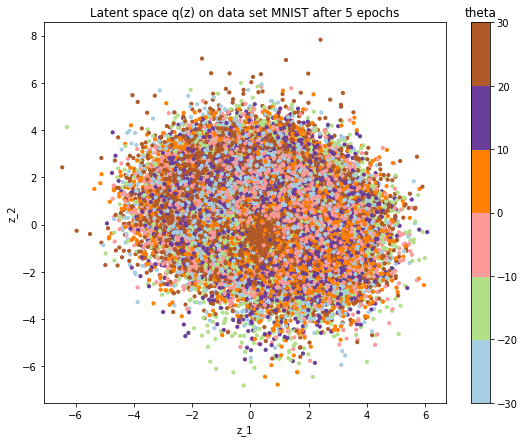

In [6]:
# visualize q(z) (latent space z)
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_diff" or key == "scale_diff" and solver.data_loader.prepro_params[key].any():
            if key == "theta_diff":
                ticks = np.arange(solver.data_loader.theta_range_2[0], solver.data_loader.theta_range_2[1]+1, 10).tolist()
            if key == "scale_diff":
                ticks = np.linspace(solver.data_loader.scale_range_2[0], solver.data_loader.scale_range_2[1], 6).tolist()
            plot_latent_space(solver, solver.z_space[-1], ticks, "z", key.split("_")[0], solver.data_loader.prepro_params["theta_diff"][-1])
else:
    print("Plot of latent space not possible as dimension of z is not 2")

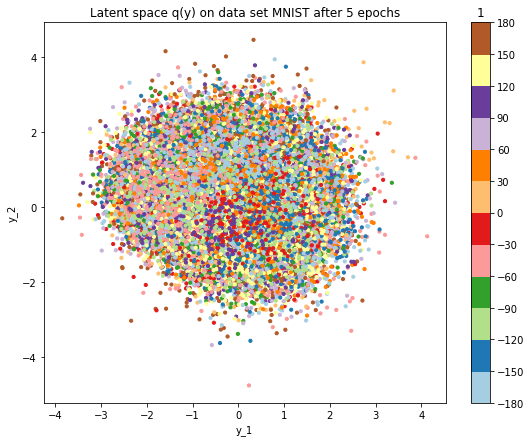

In [5]:
# visualize q(y)
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            if key == "theta_1":
                ticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
            if key == "scale_1":
                ticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
            plot_latent_space(solver, solver.y_space[-1], ticks, "y", key.split("_")[1], solver.data_loader.prepro_params[key][-1])
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if not load_model:   
    if solver.z_dim == 2:
        n = 11
        if solver.data_loader.thetas:
            grid_x = np.linspace(-4, 4, n)
            grid_y = np.linspace(-4, 4, n)
        elif solver.data_loader.scales:
            grid_x = np.linspace(-3, 3, n)
            grid_y = np.linspace(-3, 3, n)
        x_t = iter(solver.data_loader.train_loader).next()[0][0][0].view(-1, solver.data_loader.input_dim)
        plot_latent_manifold(solver, "bone", grid_x, grid_y, n, x_t=x_t)
    else:
        print("Plot is not possible as dimension of z is not 2")

In [ ]:
# Bar chart over the different theta_1/scale_1 used for y_t
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            if key == "theta_1":
                xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
                plot_prepro_params_distribution(solver, xticks, key, "Angle distribution for y_t", "Count")
            if key == "scale_1":
                xticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
                plot_prepro_params_distribution(solver, xticks, key, "Scaling distribution for y_t", "Count")
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
# distribution of angles/scales with categeries/classes of dataset as bins
if solver.z_dim == 2 and solver.data_loader.with_labels:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            ytitle = "Number of elements in each bin"
            if key == "theta_1":
                xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
                plot_prepro_params_distribution_categories(solver, xticks, key, "Distribution of angles by labels", ytitle)
            if key == "scale_1":
                xticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
                plot_prepro_params_distribution_categories(solver, xticks, key, "Distribution of scales by labels", ytitle)
else:
    print("Plot of y space not possible as dimension of z is not 2 or no labeled data")

In [ ]:
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1":
            alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
            alphas = [round(x,2) for x in alphas.tolist()]
            alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
            alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
            xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist() # theta bins
            theta_alpha = list(zip(solver.data_loader.prepro_params[key], alphas)) # each theta_1 and alpha_1 paired
            plot_prepro_params_distribution(solver, xticks, key, "Archtangents distribution for y_t", "alpha distribution for theta_1 bins", data=(theta_alpha, alpha_bins))
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
if solver.z_dim == 2 and solver.data_loader.with_labels:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1":
            alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
            alphas = [round(x,2) for x in alphas.tolist()]
            alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
            alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
            theta_bins = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist() # theta bins
            theta_alpha_label = list(zip(solver.data_loader.prepro_params[key], alphas, solver.data_labels)) # each theta_1i, alpha_1i, y_i paired
            plot_prepro_params_distribution_categories(solver, theta_bins, key, "Distribution of archtangents by labels", "alpha distribution for theta_1 in bins", data=(theta_alpha_label, alpha_bins))
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
# for rotation
if solver.z_dim == 2 and solver.data_loader.thetas:
    plot_prepro_alpha_params_distribution(solver)
else:
    print("dim(z) is not 2 or rotation mode is not set")

In [ ]:
# for scaling
if solver.z_dim == 2 and solver.data_loader.scales:
    plot_prepro_radius_params_distribution(solver)
else:
    print("dim(z) is not 2 or scaling mode is not set")

In [ ]:
thetas = np.radians(solver.data_loader.prepro_params["theta_1"])
#print(thetas.shape, thetas[:,0].T)
#print(thetas[:,0].T.shape)
#print(np.repeat(thetas[:,0].T, solver.data_loader.num_train_samples))
#print(np.repeat(solver.data_loader.prepro_params["theta_1"][:,0].T, solver.data_loader.num_train_samples))
print(len(solver.data_loader.prepro_params["theta_1"][:, 0]))
#print(solver.y_space.shape)
M, N, D = solver.y_space.shape
print(solver.y_space.reshape((N, M, D)).shape)
print(solver.data_loader.prepro_params["theta_1"][0,:])

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla


alphas = torch.atan2(torch.tensor(solver.y_space[:,:,0]-np.mean(solver.y_space[:,:,0])), torch.tensor(solver.y_space[:,:,1]-np.mean(solver.y_space[:,:,1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
# TODO:
alphas = alphas[0,:]
classes = solver.data_labels
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:]))

# TODO: fix thetas...
print(alphas.shape)
thetas = solver.data_loader.prepro_params["theta_1"][0] #np.radians(solver.data_loader.prepro_params["theta_1"][0].T)
print(thetas)
print(np.min(thetas), np.max(thetas))

#paired_cmap = plt.cm.get_cmap("Paired", 12)
#rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
#norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas), len(new_counts), indices, np.min(thetas[indices]), np.max(thetas[indices]))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
solver = torch.load("../results/saved_models/model_TD_CVAE_MNIST_train_loss=88.61_z=2.pt", map_location='cpu')
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
solver.model.eval()


alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
alphas = np.array([round(x,2) for x in alphas.tolist()])
# TODO: problem: for each batch_size, there are num_generation (thetas, alphas), we have to take that into account!
#thetas = np.repeat(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
classes = np.array(solver.data_labels)
#y_space_labels = np.repeat(solver.data_loader.prepro_params[key], solver.data_loader.batch_size)
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
#print(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
# TODO: make alphas bins and count, but then flatten the counts, and mark by counts values where each new color begins.
#print(np.sum(counts))
#print(alphas.shape, len(thetas), solver.y_space.shape, len(solver.data_loader.prepro_params["theta_1"]), classes)
# move every 10, because every 10th is the angle for index 0.
thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(thetas.shape)

paired_cmap = plt.cm.get_cmap("Paired", 12)
rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
print(alpha_bins)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    #print(counts.sum(), len(alphas_indices))
    #print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        #print(asd, offset, to_fill.shape)
        new_counts[asd:(asd+offset)] = to_fill # 0:len(to_fill), len(to_fill):len(new_to_fill)
        asd += offset
    print(len(new_counts))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
#solver.model.eval()
# compute the alphas
alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    #if idx > 0:
    #    alphas[:, idx] -= alphas[:, 0]
alphas = np.around(np.array(alphas), decimals=2)
# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for gen in range(solver.num_generations):
    thetas[:, gen] = np.radians(np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size))
#thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(alphas.shape, thetas.shape)
# create the alphas bins, corresponding to the same number as theta bins
mini = np.min(alphas)
maxi = np.max(alphas)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
    
print(alphas.shape, thetas.shape)
    #paired_cmap = plt.cm.get_cmap("Paired", 12)
    #rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
    #norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
solver.model.eval()

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

# compute the alphas
alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)

# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
# For each batch we go through num_generations iterations/encodings. Thus, 
# if num_generations is 10, for prepro_params, 0-9 is for batch 0, 10-19 for batch 1 and so on. (every time on the same batch)  
idx = 0
for batch_idx in range(solver.data_loader.num_train_batches):
    start = batch_idx*solver.data_loader.batch_size
    end = (batch_idx+1)*solver.data_loader.batch_size
    for gen in range(solver.num_generations):
        thetas[start:end, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][idx], solver.data_loader.batch_size)
        idx += 1
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)

mini = np.min(alphas)
maxi = np.max(alphas)
print(mini, maxi)
for idx in range(0, alphas.shape[1]):
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    if idx > 0:
        alphas[:, idx] = np.around(alphas[:, idx] - alphas[:, 0] + (np.radians(thetas[:, 0])/(2*np.pi))-0.5, decimals=2)
        #mini = np.min(alphas[:, idx])
        #maxi = np.max(alphas[:, idx])
        #print(mini, maxi)
        #print(np.min(alphas[:, idx]), np.max(alphas[:, idx]))
        neg_indices = np.where(alphas[:, idx] < -0.5)
        pos_indices = np.where(alphas[:, idx] > 0.5)
        alphas[neg_indices, idx] = mini % alphas[neg_indices, idx]
        alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx]
        print(np.min(alphas[:, idx]), np.max(alphas[:, idx]))

# create the alphas bins, corresponding to the same number as theta bins
mini = np.min(alphas)
maxi = np.max(alphas)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
alphas = np.around(np.array(alphas), decimals=2)

alpha_ranges = alpha_ranges[:-1]
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(np.radians(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

'''
alphas = torch.atan2(torch.tensor(solver.y_space[:,:,0]-np.mean(solver.y_space[:,:,0])), torch.tensor(solver.y_space[:,:,1]-np.mean(solver.y_space[:,:,1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
# TODO:
alphas = alphas[0,:]
classes = solver.data_labels
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:]))

# TODO: fix thetas...
print(alphas.shape)
thetas = solver.data_loader.prepro_params["theta_1"][0] #np.radians(solver.data_loader.prepro_params["theta_1"][0].T)
print(thetas)
print(np.min(thetas), np.max(thetas))


# compute the alphas
M, N, D = solver.y_space.shape
new_y_space = solver.y_space.reshape((N, M, D))
alphas = torch.zeros((new_y_space.shape[1], new_y_space.shape[2])) # used to be N, D
thetas = np.zeros_like(alphas)
#print(solver.y_space.shape, new_y_space.shape, alphas.shape)
#print(torch.tensor(solver.y_space[: idx, 0]-np.mean(solver.y_space[:, idx, 0])).shape)
for idx in range(solver.y_space.shape[0]):
    print("haha", (torch.tensor(new_y_space[: idx, 0]-np.mean(new_y_space[:, idx, 0]))))
    #alphas[:, idx] = torch.atan2(torch.tensor(new_y_space[: idx, 0]-np.mean(new_y_space[:, idx, 0])),\
    #        torch.tensor(new_y_space[:, idx, 1]-np.mean(new_y_space[:, idx, 1])))/(2*np.pi)
    #thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    #if idx > 0:
    #    alphas[:, idx] -= alphas[:, 0]

# TODO:oK?
alphas = torch.zeros((solver.y_space.shape[1], solver.y_space.shape[0]))
thetas = np.zeros_like(alphas)
for idx in range(solver.y_space.shape[0]):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    if idx > 0:
        alphas[:, idx] = alphas[:, idx]
'''

# M, N, 2
print(solver.data_loader.prepro_params["theta_1"].shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
alphas = torch.zeros((N, M))
thetas = np.zeros_like(alphas)
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
        
alphas = np.around(np.array(alphas), decimals=2)
mini = np.min(alphas)
maxi = np.max(alphas)
print(mini, maxi)
print(alphas.shape, thetas.shape)
print(thetas[100:200])

# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, M), decimals=2)
alpha_ranges = alpha_ranges[:-1]
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        print(i, alphas_indices[:, i].shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thetas[indices].flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

(59904, 6)
0 (5917, 5)
1 (5917, 5)
2 (5917, 5)
3 (5917, 5)
4 (5917, 5)
29585 29585
0 (6736, 5)
1 (6736, 5)
2 (6736, 5)
3 (6736, 5)
4 (6736, 5)
33680 33680
0 (5951, 5)
1 (5951, 5)
2 (5951, 5)
3 (5951, 5)
4 (5951, 5)
29755 29755
0 (6120, 5)
1 (6120, 5)
2 (6120, 5)
3 (6120, 5)
4 (6120, 5)
30600 30600
0 (5834, 5)
1 (5834, 5)
2 (5834, 5)
3 (5834, 5)
4 (5834, 5)
29170 29170
0 (5410, 5)
1 (5410, 5)
2 (5410, 5)
3 (5410, 5)
4 (5410, 5)
27050 27050
0 (5902, 5)
1 (5902, 5)
2 (5902, 5)
3 (5902, 5)
4 (5902, 5)
29510 29510
0 (6251, 5)
1 (6251, 5)
2 (6251, 5)
3 (6251, 5)
4 (6251, 5)
31255 31255
0 (5838, 5)
1 (5838, 5)
2 (5838, 5)
3 (5838, 5)
4 (5838, 5)
29190 29190
0 (5945, 5)
1 (5945, 5)
2 (5945, 5)
3 (5945, 5)
4 (5945, 5)
29725 29725


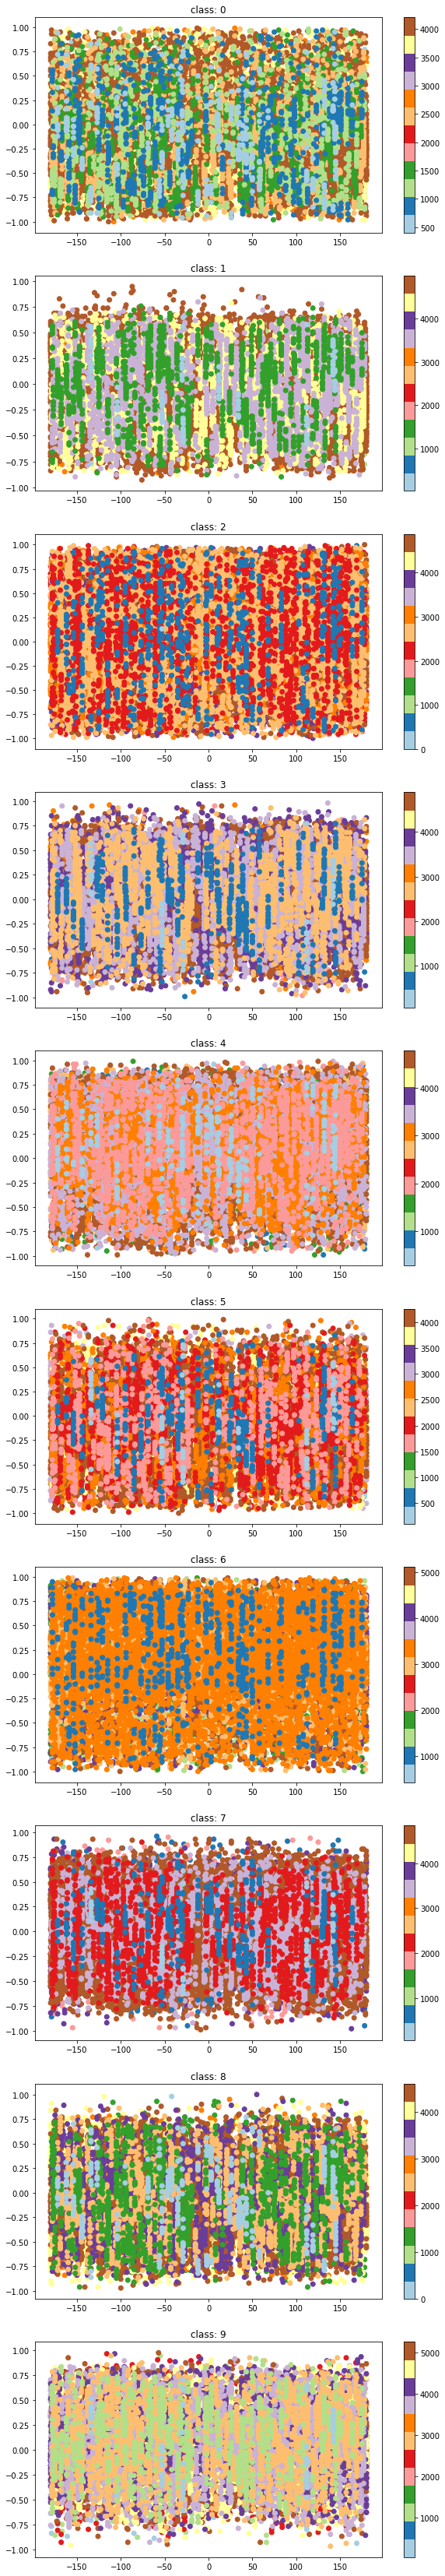

In [11]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

######################################################################

'''
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
M = 2
alphas = np.zeros((N, M))
thetas = np.zeros_like(alphas)
alphas[:, 0] = (torch.atan2(torch.tensor(solver.y_space[0, :, 0]-np.mean(solver.y_space[0, :, 0])),\
            torch.tensor(solver.y_space[0, :, 1]-np.mean(solver.y_space[0, :, 1])))/(2*np.pi)).numpy()
alphas[:, 1] = (torch.atan2(torch.tensor(solver.y_space[1, :, 0]-np.mean(solver.y_space[1, :, 0])),\
            torch.tensor(solver.y_space[1, :, 1]-np.mean(solver.y_space[1, :, 1])))/(2*np.pi)).numpy()
alphas[:, 1] -= alphas[:, 0]
alphas = np.around(alphas, decimals=2)
thetas[:, 0] = solver.data_loader.prepro_params["theta_1"][0]
thetas[:, 1] = solver.data_loader.prepro_params["theta_1"][1]
'''

'''
M=1
alphas = torch.zeros((N, 1))
thetas = np.zeros_like(alphas)
alphas[:, 0] = torch.atan2(torch.tensor(solver.y_space[0, :, 0]-np.mean(solver.y_space[0, :, 0])),\
            torch.tensor(solver.y_space[0, :, 1]-np.mean(solver.y_space[0, :, 1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
thetas[:, 0] = solver.data_loader.prepro_params["theta_1"][0]
'''

N, M = solver.y_space.shape[1], solver.y_space.shape[0]
alphas = torch.zeros((N, M))
thetas = np.zeros_like(alphas)
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    alphas = np.around(np.array(alphas), decimals=2)
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
        #neg_indices = np.where(alphas[:, idx] < -0.5)
        #pos_indices = np.where(alphas[:, idx] > 0.5)
        #alphas[neg_indices, idx] = mini % alphas[neg_indices, idx]
        #alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx]
alphas = np.around(np.array(alphas), decimals=2)



mini = np.min(alphas)
maxi = np.max(alphas)
# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
print(alphas.shape)
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices, 1:] # , 1:
    for i in range(alphas_indices.shape[1]):
        print(i, alphas_indices.shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    thets = thetas[indices, 1:] # , 1:
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thets.flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thets.flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
radiuses = np.zeros((solver.y_space.shape[0], solver.num_generations))
centroid = np.mean(solver.y_space[:, :2], axis=0)
# compute the euclidean distance from each point y_{ij} to the center, so the radiuses
#print(solver.data_loader.train_loader.dataset.transform.transforms.prepro_params)
#print(solver.data_loader.prepro_params["scale_1"])
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)):
    radiuses[:, idx] = bla.cdist(solver.y_space[:, gen_idx:gen_idx+2], np.atleast_2d(centroid)).ravel()
    if idx > 0:
        radiuses[:, idx] -= radiuses[:, 0]
    #radiuses = np.around(np.array(radiuses), decimals=2)
    # prepare the scale from each batch, repeat each set of scales to span over num train samples
#print(solver.data_loader.prepro_params)
scales = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for idx in range(solver.num_generations):
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    scales[:, idx] = np.repeat(solver.data_loader.prepro_params["scale_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    # create the alphas bins, corresponding to the same number as theta bins
mini = np.min(radiuses)
maxi = np.max(radiuses)
radius_ranges = np.around(np.linspace(mini, maxi, 5), decimals=2)
radius_bins = list(zip(radius_ranges[:-1], radius_ranges[1:]))

fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10, 60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(radius_bins))
    radius_indices = radiuses[indices]
    for i in range(radiuses.shape[1]):
        for alpha in radius_indices[:, i]:
            for bin_idx, (x, y) in enumerate(radius_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(radius_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    scatter = ax.scatter(scales[indices, :].flatten(), radius_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
mode = ""
if solver.data_loader.thetas and solver.data_loader.scales:
    mode = "SCALES_THETAS_"
elif solver.data_loader.thetas:
    mode += "THETAS_"
elif solver.data_loader.scales:
    mode += "SCALES_"
torch.save(solver, solver.data_loader.directories.result_dir + "/model_TD_CVAE_" + mode + solver.data_loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")